# Decision Tree

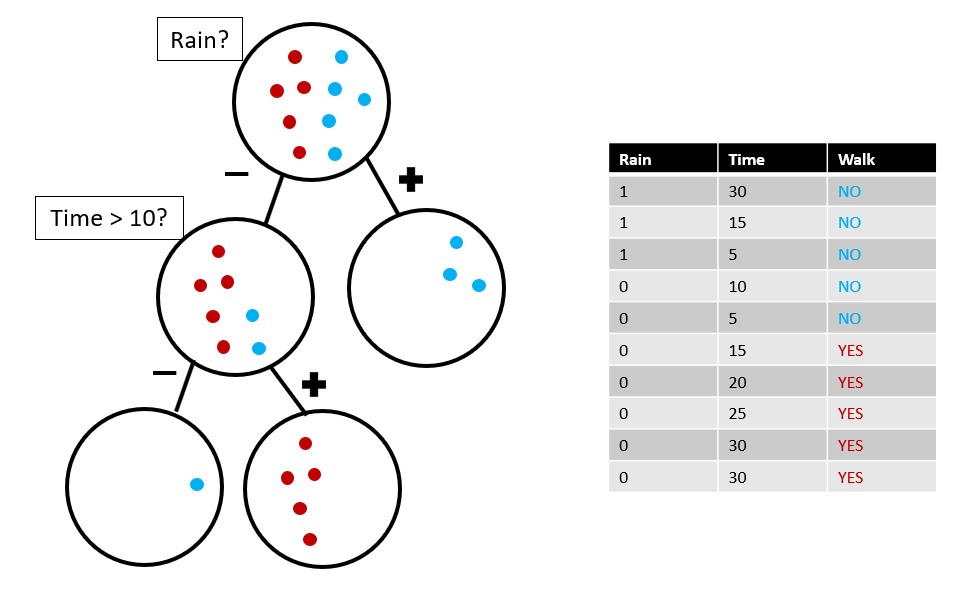

- supervised learning Algorithm


- Create a tree, that splits the data to have the best seperation of classes


- to find the best feature splits and feature value thresholds, use the **Entropy** to calculate the **uncertanity**





## Entropy

$
E = - \sum p(X) \cdot log_2(p(X)) \quad (1.1)
$


- E = 0 is the best possible case (completely certain)

- E = 1 is the worst possible case (completely uncertain)






$
p(X) = \frac{\text{number of occurences}}{\text{total number of samples}}  \quad (1.2)
$

After entropy calculation, calculate the **information gain**

## Information Gain

$
IG = E(parent) - [\text{weighted average}] \cdot E(children) \quad (1.3)
$

## Total Approach
### Train algorithm: Build the tree

- For a given tree depth: start at the top node and select the best split based on the best information gain


- Greedy search: Loop over all features and over all thresholds (all possible feature values)


- Save the best split feature and split threshold at each node


- build the tree recursively


- Apply some stopping criteria to stop growing (e.g. maximum depth)


- When reaching a leaf node, store the most common class label of this node



### Predict: Traverse Tree

- Traverse the tree

In [76]:
import numpy as np
from collections import Counter

# global function to calculate the entropy (see eq. 1.1)
def calculate_entropy(y):
    
    # calculate p(X) (see eq 1.2), so an array of each p(x)
    histogram = np.bincount(y)
    p_of_X = histogram / len(y)

    # apply eq 1.1 for each p(x) and return
    return -np.sum([p_of_x * np.log2(p_of_x) for p_of_x in p_of_X if p_of_x > 0])


# helperclass to store information about a node
class Node: 
    def __init__(self, feature = None, threshold = None, left_children = None, right_children = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left_children = left_children
        self.right_children = right_children
        self.value = value
        
    # helperfunction to check, if the current node is a leaf node or not
    def is_leaf_node(self):
        
        # check, if the current node has a value (which has each leaf node, see image above),
        # and return the answer as bool
        return self.value is not None
        
        
        
class DecisionTree:
    
    # min_samples_split is the minimal value of samples to further split the tree
    # n_features can be specified; use this in order not to do a greedy search, but loop only over
    # a subset of features; this will be selectred randomly (needed for Random Forest later)
    def __init__(self, min_samples_split = 2, max_depth = 100, n_feats = None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        
        
    # method to grow the tree using X as matrix of training features and y as training labels    
    def fit(self, X, y):
        
        # get the amount of features if n_features is not specified (in order to only use a subset)
        # X is an m x n array where m represents the amount of training data samples and n the amount of features
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow_tree(X, y)        
        
        
    # helperfunction to grow the tree iterativly, taking the training data and a variable depth, to check
    # the current depth in each iteration
    def grow_tree(self, X, y, depth = 0):
        
        # get the amount of features if n_features is not specified (in order to only use a subset)
        # X is an m x n array where m represents the amount of training data samples and n the amount of features
        n_samples, n_features = X.shape
        
        # get the amount of unique training labels
        n_labels = len(np.unique(y))
        
        # stopping criteria: max depth reached OR minimum samples at node reached OR no more class distribution in node
        # if any of this is true, we are at a leaf node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            # if we have reached  a leaf node, the final output is the most occuring label
            leaf_value = self.get_most_common_label(y)
            
            # create and return the leaf node object using the Node class from above
            return Node(value = leaf_value)
        
        # get random feature indices between 0 and n_features
        feature_indices = np.random.choice(n_features, self.n_feats, replace = False)
             
        # apply greedy search
        
        # get the best feature and threshold
        best_feature, best_threshold = self.get_best_criteria(X, y, feature_indices)
        
        left_indices, right_indices = self.split(X[:, best_feature], best_threshold)
        
        # continue growing
        left_children = self.grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_children = self.grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        
        return Node(best_feature, best_threshold, left_children, right_children)       
           

    # helperfunction to get the most occuring label in a leaf node
    def get_most_common_label(self, y):
        
        # Counter() will sum up all the occurences of y's
        label_histogram_in_leaf_node = Counter(y)
        
        # use the Counter base method most_common(n) to get the n (here 1) most common label.
        # the return is a list of touple, of the form [value, n_occurences] 
        most_common = label_histogram_in_leaf_node.most_common(1)[0][0]
        
        return most_common
        
        
    # helperfunction to go over all features and all feature values and calculate the
    # information gain each time
    def get_best_criteria(self, X, y, feature_indices):
        
        # initialize parameter
        best_gain = -1
        split_index, split_threshold = None, None    
        
        for feature_index in feature_indices:
            # extract the X-column vector of the current split index
            X_column = X[:, feature_index]
            
            # go over all possible thresholds (aka values) in this X-column. In the 
            # example image above it would be, checking all time values in the time column
            # (but just once) and calculating the information gain for each
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self.calculate_information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold
        
        return split_index, split_threshold
    
    
    # helperfunction to calculate the information gain according to eq. (1.3)
    def calculate_information_gain(self, y, X_column, split_threshold):
        
        # remember: IG is the entropy of a parents' node - weighted avg of the childrens' entropy
        # so
        # 1) calculate parents' entropy
        parent_entropy = calculate_entropy(y)
        # 2) generate split using the split() helpermethod
        left_indices, right_indices = self.split(X_column, split_threshold)
        
        # check if there don't exist any indices in a left or right path anymore --> 
        # we have reached the leaf node and no information gain is possible anymore
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        
        # 3) calculate weighted average of childrens' entropy
        n_samples = len(y)
        n_left_indices, n_right_indices = len(left_indices), len(right_indices)
        entropy_of_left_indices = calculate_entropy(y[left_indices])
        entropy_of_right_indices = calculate_entropy(y[right_indices])
        child_entropy = (n_left_indices / n_samples) * entropy_of_left_indices + \
                        (n_right_indices / n_samples) * entropy_of_right_indices
        
        information_gain = parent_entropy - child_entropy
        
        return information_gain
    
    
    # helperfunction to create a split in a node
    def split(self, X_column, split_threshold):
        
        # np.arghwere will return an array, where all the set condition is true; 
        # also flatten this in order to get only a 1D-vector
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        
        return left_indices, right_indices      
       
        
    def predict(self, X):
        # traverse tree for each sample row x in an X sample matrix
        return np.array([self.traverse_tree(x, self.root) for x in X])
    
    
    # function to traverse the grown tree with a given data point x
    def traverse_tree(self, x, node):
        # check if we already have reached a leaf node; then return its value
        if node.is_leaf_node():
            return node.value
        # if the current feature index <= threshold --> traverse to the left; else to the right
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left_children)
        else:
            return self.traverse_tree(x, node.right_children)
     
    
    # function to calculate the accuracy of the model 
    def calculate_accuracy(self, y_hat, y_test):
        self.accuracy = np.sum(y_hat == y_test) / len(y_hat)
        return self.accuracy            

# Test the model

In [77]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# generate example training data
data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

# instantiate a classifier object
decision_tree_classifier = DecisionTree(max_depth = 100)

# train the model
decision_tree_classifier.fit(X_train, y_train)

y_hat = decision_tree_classifier.predict(X_test)

print(decision_tree_classifier.calculate_accuracy(y_hat, y_test))

0.9298245614035088
